We shall conduct some exploratory data analysis on the flights dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
df = pd.read_csv('../Data/Processed/model_ready_airline_fares.csv')

# Calculate Price per mile
df["fare"] = df["fare_real"] # To resolve variable  name conflicts
df['price_per_mile'] = df['fare'] / df['nsmiles']



# Filter for rows that have at least one NaN/missing value
missing_rows = df[df.isnull().any(axis=1)]

# Display total count and the first few rows
print(f"Total rows with missing values: {len(missing_rows)}")
print(missing_rows.head())

df = df.dropna()
df.head()

Total rows with missing values: 0
Empty DataFrame
Columns: [Year, Quarter, city_1, city_2, state_1, state_2, nsmiles, passengers, fare_real, large_ms, fare_lg_real, carrier_low, lf_ms, fare_low_real, TotalFaredPax_city1, TotalPerLFMkts_city1, TotalPerPrem_city1, TotalFaredPax_city2, TotalPerLFMkts_city2, TotalPerPrem_city2, median_income_1, median_income_2, metro_1, metro_2, TotalFaredTotal, fare, price_per_mile]
Index: []

[0 rows x 27 columns]


,Year,Quarter,city_1,city_2,state_1,state_2,nsmiles,passengers,fare_real,large_ms,...,TotalFaredPax_city2,TotalPerLFMkts_city2,TotalPerPrem_city2,median_income_1,median_income_2,metro_1,metro_2,TotalFaredTotal,fare,price_per_mile
0,2022,1,Miami,New York City,FL,NY,1139,17803,179.83,0.3022,...,1.973783e+06,0.8484,-0.055833,69303.0,79557.0,True,True,6.092953e+06,179.83,0.157884
1,2022,1,Los Angeles,San Francisco,CA,CA,372,11272,133.08,0.6098,...,1.969430e+06,0.8430,-0.043600,91551.0,91551.0,True,True,4.031700e+06,133.08,0.357742
2,2022,1,New York City,Orlando,NY,FL,989,10113,162.02,0.3329,...,7.232690e+06,0.9551,-0.023300,79557.0,69303.0,True,False,9.206473e+06,162.02,0.163822
3,2022,1,Los Angeles,New York City,CA,NY,2510,9590,315.77,0.2788,...,1.973783e+06,0.8484,-0.055833,91551.0,79557.0,True,True,4.036053e+06,315.77,0.125805
4,2022,1,New York City,West Palm Beach/Palm Beach,NY,FL,1056,5952,218.28,0.4778,...,1.440510e+06,0.8370,0.183300,79557.0,69303.0,True,False,3.414293e+06,218.28,0.206705


First, we'll check correlation between variables

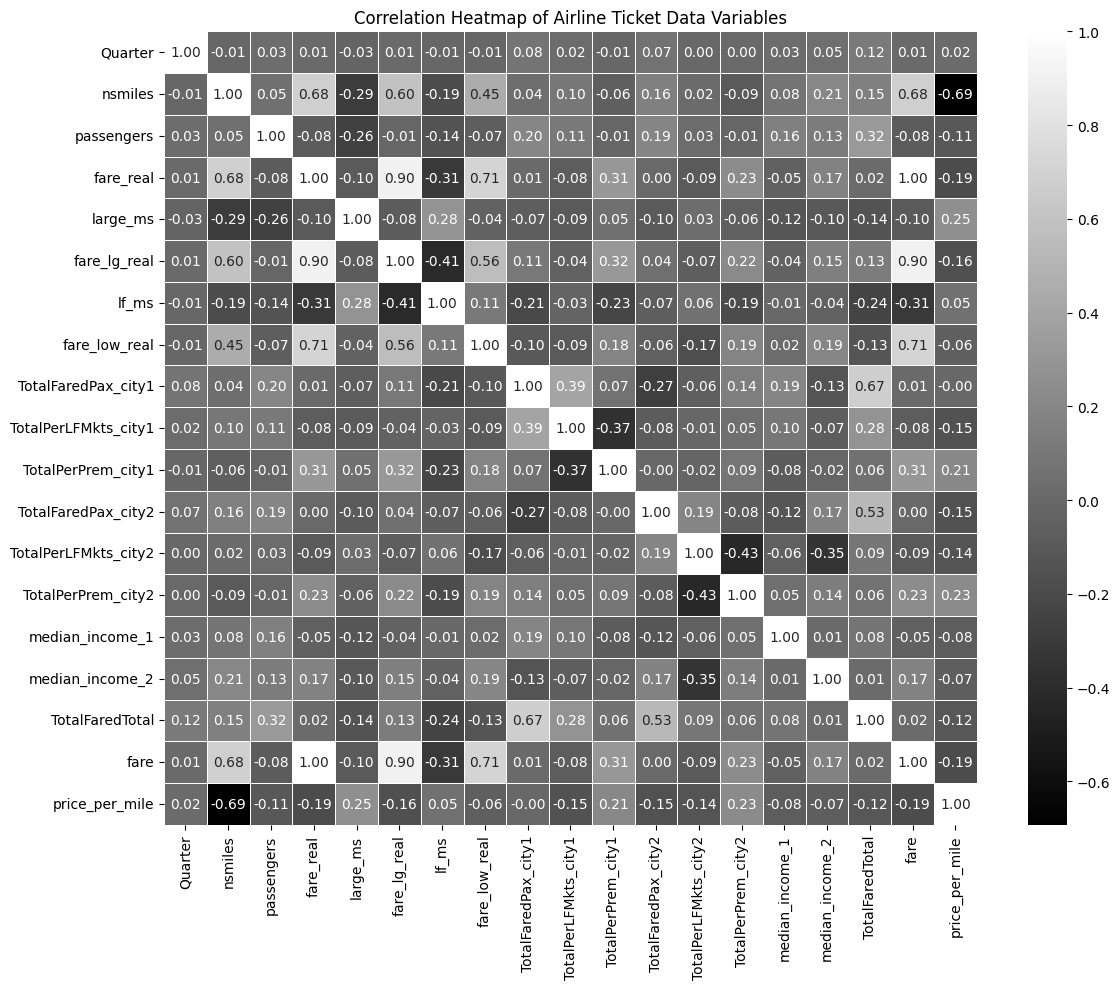

In [4]:
# Correlation Heatmap
# Select numeric columns for correlation analysis, excluding IDs and Year/Quarter
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
cols_to_corr = [col for col in numeric_cols if col not in ['citymarketid_1', 'citymarketid_2', 'Year', 'quarter']]
corr_matrix = df[cols_to_corr].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='gray', linewidths=0.5)
plt.title('Correlation Heatmap of Airline Ticket Data Variables')
plt.tight_layout()

First, we'll graph fare trends over time to see whether we have to adjust for inflation or other external factors

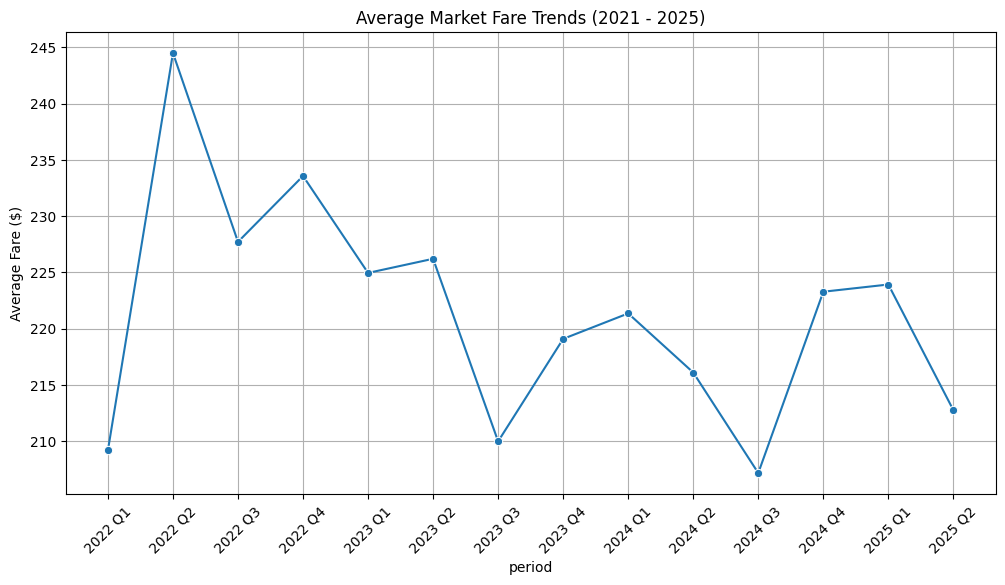

In [7]:
# Fare trends over time (Year/Quarter)
df['period'] = df['Year'].astype(str) + ' Q' + df['Quarter'].astype(str)
fare_trends = df.groupby('period')['fare'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=fare_trends, x='period', y='fare', marker='o')
plt.title('Average Market Fare Trends (2021 - 2025)')
plt.xticks(rotation=45)
plt.ylabel('Average Fare ($)')
plt.grid(True)
plt.savefig('../Data/docs/images/fare_trends_over_time.png')

Average fares show significant volatility. There was a notable peak in early 2022 and another in early 2025, suggesting seasonal demand spikes or macroeconomic factors (like fuel price changes) that affect the baseline price regardless of the route.

Does higher dominant market share lead to higher prices?

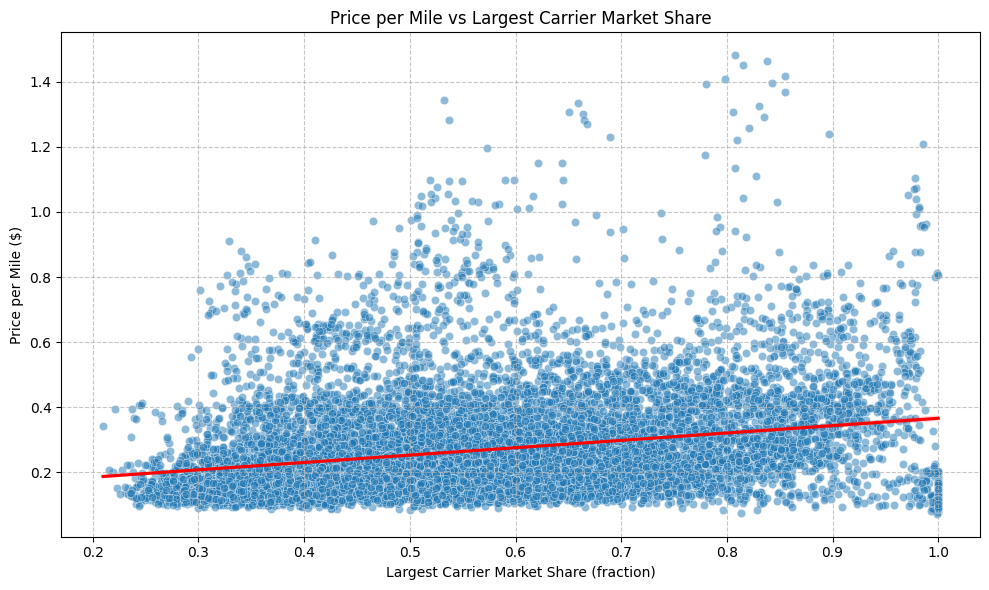

       price_per_mile      large_ms
count    14004.000000  14004.000000
mean         0.268285      0.566322
std          0.155232      0.174240
min          0.073057      0.209700
25%          0.165337      0.431800
50%          0.221171      0.541600
75%          0.322733      0.676725
max          1.480863      1.000000


In [9]:
# 2. Price per Mile against Market Share (large_ms)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='large_ms', y='price_per_mile', alpha=0.5)
# Adding a trend line to visualize the relationship
sns.regplot(data=df, x='large_ms', y='price_per_mile', scatter=False, color='red')
plt.title('Price per Mile vs Largest Carrier Market Share')
plt.xlabel('Largest Carrier Market Share (fraction)')
plt.ylabel('Price per Mile ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('../Data/docs/images/ppm_vslargest_carrier_ms')
plt.show()

# Display basic statistics for context
print(df[['price_per_mile', 'large_ms']].describe())

We find a positive correlation here. Specifically, the higher the market share of the dominant airline, the higher the average fare of tickets.

Conversely, do Low Cost Carrier penetration impact prices? 

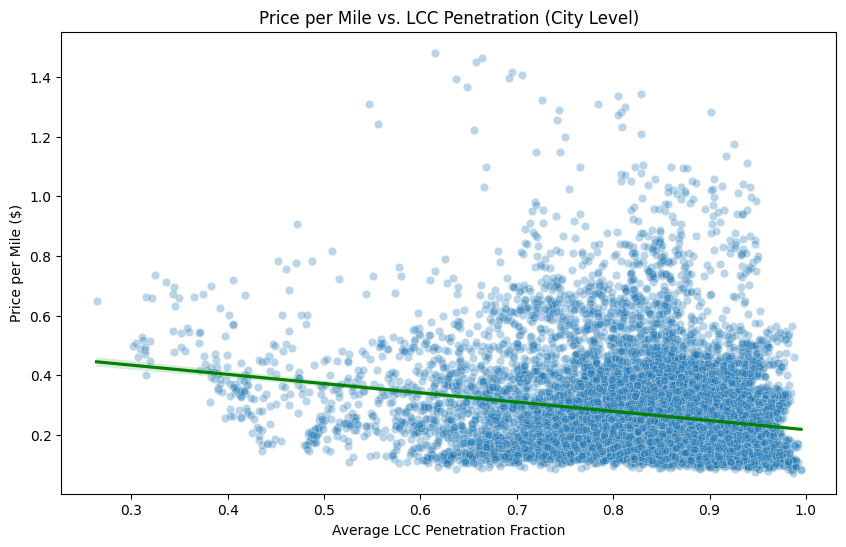

In [11]:
# Impact of LCC Presence (TotalPerLFMkts) on Price per Mile
# We'll use the average of city1 and city2 LCC penetration as a proxy for the route
df['avg_lcc_penetration'] = (df['TotalPerLFMkts_city1'] + df['TotalPerLFMkts_city2']) / 2

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='avg_lcc_penetration', y='price_per_mile', alpha=0.3)
sns.regplot(data=df, x='avg_lcc_penetration', y='price_per_mile', scatter=False, color='green')
plt.title('Price per Mile vs. LCC Penetration (City Level)')
plt.xlabel('Average LCC Penetration Fraction')
plt.ylabel('Price per Mile ($)')
plt.savefig('../Data/docs/images/price_vs_lcc_penetration.png')

Yep, with the opposite effect. The higher the penetration, the lower the prices

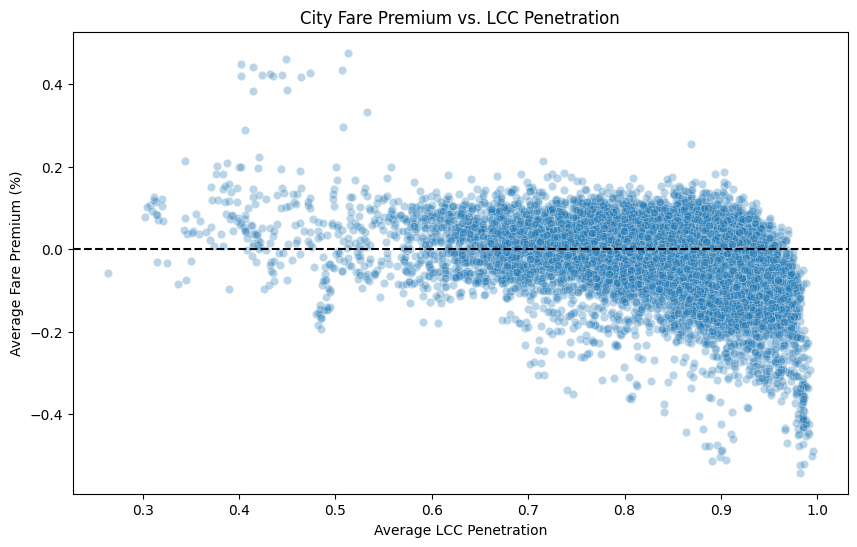

In [13]:
# 3. Identifying "Monopoly Hubs" vs "Consumer Havens"
# High Fare Premium vs Low LCC Penetration
df['avg_fare_premium'] = (df['TotalPerPrem_city1'] + df['TotalPerPrem_city2']) / 2

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='avg_lcc_penetration', y='avg_fare_premium', alpha=0.3)
plt.axhline(0, color='black', linestyle='--')
plt.title('City Fare Premium vs. LCC Penetration')
plt.xlabel('Average LCC Penetration')
plt.ylabel('Average Fare Premium (%)')
plt.savefig('../Data/docs/images/premium_vs_lcc.png')

Markets in the top-left of the chart (Low LCC penetration, High Fare Premium). These are cities locked down by legacy carriers where consumers pay significantly more.

Markets in the bottom-right (High LCC penetration, Negative Fare Premium). These are markets where competition effectively keeps prices below average.

In Conclusion, ticket prices are very much determined by market conditions. This result will be valuable in guiding our analysis.